In [11]:
%%script false --no-raise-error --no-raise-exception
# %%capture --no-stderr
!pip install PyYAML==6.0.2
!pip install matplotlib==3.9.2
!pip install networkx==3.4.1
!pip install pyvis==0.3.2
!pip install folium==0.17.0
!pip install ipympl==0.9.4
!pip install langchain==0.3.3
!pip install langchain-core==0.3.10
!pip install langchain-community==0.3.2
!pip install langchain-ollama==0.2.0
!pip install langchain-experimental==0.3.2
!pip install langgraph==0.2.35
!pip install langchain-openai==0.2.2
!pip install openmindat==0.0.9

# Prerequisites

In [1]:
import yaml
import os

# Function to read YAML file
def read_yaml(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'r') as file:
            try:
                content = yaml.safe_load(file)
                return content
            except yaml.YAMLError as exc:
                print(f"Error reading YAML file: {exc}")
                return None
    else:
        return None

# Function to write YAML file
def write_yaml(file_path, data):
    with open(file_path, 'w') as file:
        try:
            yaml.dump(data, file, default_flow_style=False)
        except yaml.YAMLError as exc:
            print(f"Error writing YAML file: {exc}")

# Path to your YAML file
yaml_file_path = '.apikey.yaml'

# Read YAML file
config = read_yaml(yaml_file_path)

# Check if the config is loaded, otherwise prompt for input
if config and 'api_key' in config:
    os.environ["MINDAT_API_KEY"] = config['api_key']
else:
    mindat_api_key = input("YAML file not found or 'mindat' key missing. Please enter your MINDAT_API_KEY: ")
    os.environ["MINDAT_API_KEY"] = mindat_api_key
    
    # Save the API key to YAML file
    new_config = {'api_key': mindat_api_key}
    write_yaml(yaml_file_path, new_config)
    print(f"API key saved to {yaml_file_path}.")

print("MINDAT_API_KEY is set.")

MINDAT_API_KEY is set.


# Construct Workflow

In [2]:
!ollama list

NAME                                                ID              SIZE      MODIFIED    
gene21d4/llama_3.1_instruct_8b_openmindat:latest    45ba34c46e72    4.9 GB    2 weeks ago    
llama-3.1-instruct-8b-openmindat:latest             45ba34c46e72    4.9 GB    2 weeks ago    
llama3.1:8b-instruct-q4_K_M                         46e0c10c039e    4.9 GB    2 weeks ago    
llama3.1:latest                                     42182419e950    4.7 GB    3 weeks ago    
llama3.2:3b                                         a80c4f17acd5    2.0 GB    4 weeks ago    
nomic-embed-text:latest                             0a109f422b47    274 MB    4 weeks ago    
mistral:latest                                      f974a74358d6    4.1 GB    4 weeks ago    
llama3:latest                                       365c0bd3c000    4.7 GB    4 weeks ago    
llama2:latest                                       78e26419b446    3.8 GB    4 weeks ago    
gemma:latest                                        a72c7f4d0a1

In [3]:
# from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage
# from langchain.chat_models import ChatOpenAI
# from langchain_community.chat_models import ChatOllama

# model = ChatOpenAI(model="gpt-4o")

# model = OllamaFunctions(
#     model="llama3:8b", 
#     format="json"
#     )

# llm = ChatOllama(model="llama3.1:latest", format='json')#, temperature=0)
llm = ChatOllama(model="llama3.1:8b-instruct-q4_K_M", format='json',  num_predict = 64)#, temperature=0)

# llm = ChatOllama(model="llama3:8b")

## Prepare Agents

### Create Agent Supervisor

It will use function calling to choose the next worker node OR finish processing.

In [4]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.llms import Ollama
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
import re

# members = ["Collector", "Network_Plotter"]

# members = ["GEOMATERIAL_COLLECTOR", "LOCALITY_COLLECTOR", "HISTOGRAM_PLOTTER", "NETWORK_PLOTTER", "HEATMAP_PLOTTER"]

members = ["GEOMATERIAL_COLLECTOR", "LOCALITY_COLLECTOR", "NETWORK_PLOTTER", "HEATMAP_PLOTTER"]
options = ["FINISH"] + members

# Schema for structured response
class NextDecision(BaseModel):
    next: str = Field(description="Choose one from {options}")
    supervisor_reason: str = Field(description="The reason for choosing the next disicion. Please respond with 'next' and 'supervisor_reason' keys, no 'tool' or 'tool_input' needed")
    # model_construct: str = Field(description="placeholder")


supervisor_example1 = {
    "next": "GEOMATERIAL_COLLECTOR",
    "supervisor_reason": "I need to collect the mineral dataset to execute the user request"
}

supervisor_example2 = {
    "next": "NETWORK_PLOTTER",
    "supervisor_reason": "The dataset is collected, and the user want to see the network visualization"
}

supervisor_example3 = {
    "next": "FINISH",
    "supervisor_reason": "The user request is fulfilled, or beyond the agent working abilities."
}

## Supervisor Router
supervisor_prompt = PromptTemplate(
    template="""
    <|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a supervisor managing a conversation between the workers: {members}. \n
    Respond with FINISH if the request is fulfilled. \n
    Following are some general steps for your references:
    Case 1, "User: i want the copper mineral datasets", please go 1. GEOMATERIAL_COLLECTOR, 2. FINISH \n
    Case 2, "User: i want the network of iron mineral", please go 1. GEOMATERIAL_COLLECTOR, 2. NETWORK_PLOTTER, 3. FINISH.\n
    Case 3, "User: i want the mineral heatmap for Brazil", please go 1. LOCALITY_COLLECTOR, 2. HEATMAP_PLOTTER, 3. FINISH.\n

    Team members description:
    - GEOMATERIAL_COLLECTOR: the geomaterial collector agent, should be called in the first place to obtain mineral dataset\n
    - LOCALITY_COLLECTOR: the mineral locality collector agent, should be called in the first place to obtain locality dataset\n
    - NETWORK_PLOTTER: the network visualization plotter agent, will plot the network, cannot plot without the dataset of GEOMATERIAL_COLLECTOR\n
    - HEATMAP_PLOTTER: the heatmap visualization plotter agent, will plot the heatmap, cannot plot without the dataset of GEOMATERIAL_COLLECTOR\n

    Your json answer in 'args' must include 'next' and "supervisor_reason" keys, \n 
    Example1: "i want you to plot network visualization for carbon and oxygen mineral but without Magnesium", please call the tool with 'args' of {supervisor_example1}\n
    Example2: "User: i want you to plot network visualization for carbon and oxygen mineral but without Magnesium, Step 0, Supervisor node: GEOMATERIAL_COLLECTOR, Step 1, Collector node: The Collector node successfully saved the dataset to /Users/blc/pyspace/Git_Mindat/mindatxllm/content/mindat_data/geomaterials_data.json", please call the tool with 'args' of {supervisor_example2}\n
    For user requests beyond the team member abilities or mineral domains, simply go FINISH.
    "User: I want to order a bottle of water", please call the tool with 'args' of  {supervisor_example3}

    Please revise your response according to {errors} if present.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Messages : {messages} \n
    Given the conversation above, who should act next?
    Or should we FINISH? Select one of: {options}
    
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["members","messages","options", "errors", "supervisor_example1", "supervisor_example2", "supervisor_example3"],
)

# llm = OllamaFunctions(model="llama3:8b", format='json')

structured_llm = llm.with_structured_output(NextDecision)
supervisor_chain = supervisor_prompt | structured_llm

# llm_with_tools = llm.bind_tools([NextDecision])
# supervisor_chain = supervisor_prompt | llm_with_tools

errors = ''

/opt/anaconda3/envs/ollama2/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


#### supervisor test

In [5]:
%%script false --no-raise-error --no-raise-exception
import re

structured_llm = llm.with_structured_output(NextDecision)
supervisor_chain = supervisor_prompt | structured_llm


messages = """User: i want you to plot network visualization for carbon and oxygen mineral but without Magnesium
Step 0, Supervisor node: COLLECTOR
Step 1, Collector node: The Collector node successfully saved the dataset to /Users/blc/pyspace/Git_Mindat/mindatxllm/content/mindat_data/geomaterials_data.json"""

errors = ''
retry_tolerance = 5

def parse_required_keys_from_llm_response(llm_response):
    # 定义所需的键
    required_keys = ["next", "supervisor_reason"]
    extracted_data = {}

    # 使用正则表达式匹配所有键值对，匹配键和值为双引号或单引号包裹的内容
    for key in required_keys:
        pattern = rf'["]({key})["](?:\s*:\s*)["](.*?)["]'
        match = re.search(pattern, llm_response, re.DOTALL)
        if match:
            extracted_data[match.group(1)] = match.group(2)

    # 检查是否所有键都被提取
    if len(extracted_data) == len(required_keys):
        return json.loads(json.dumps(extracted_data))
    else:
        missing_keys = set(required_keys) - set(extracted_data.keys())
        raise ValueError(f"Missing keys in LLM response: {missing_keys}")

for retry_count in range(retry_tolerance):
    print(f"Retrying({retry_count + 1}/{retry_tolerance})")
    try:
        result = supervisor_chain.invoke({
            "members": members, 
            "messages": str(messages), 
            "options": options, 
            "errors": errors,
            "supervisor_example1": supervisor_example1,
            "supervisor_example2": supervisor_example2,
            "supervisor_example3": supervisor_example3,
        })

        print("supervisor output: ", result)

        result_next = result.next  # Access the 'next' attribute of the NextDecision object
        if result_next.upper() in options:
            break
        else:
            jargon_errors = f"{result_next} not in {options}, please try again."
            errors = jargon_errors
            print("Jargon errors: ", jargon_errors)

    except ValueError as e:
        print("Parsing...")
        print(e)
        print(parse_required_keys_from_llm_response(str(e)))
        # raise SystemExit("Terminating execution")
    except (KeyError, IndexError, AttributeError) as e:
        error_type = type(e).__name__
        errors = f"{error_type}: {str(e)}"
        print(errors)

print("supervisor test done")

### Create Action Agents

#### Geomaterial Collector

In [6]:
#from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
# from langchain_experimental.tools import PythonREPLTool

# Import things that are needed generically

from langchain.tools import BaseTool, StructuredTool, tool
from openmindat import GeomaterialSearchRetriever
import json, pprint


# tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
# python_repl_tool = PythonREPLTool()


In [7]:
from typing import Annotated, List, Tuple, Union, Optional
from langchain.pydantic_v1 import BaseModel, Field
from openmindat import GeomaterialRetriever
from pathlib import Path

class GeomaterialQueryDict(BaseModel):
    ima: Optional[bool] = Field(description="Only IMA-approved names, should be True by default")
    hardness_min: Optional[Union[float,str]] = Field(description="Mohs hardness from, leave as '' if necessary")
    hardness_max: Optional[Union[float,str]] = Field(description="Mohs hardness to, leave as '' if necessary")
    crystal_system: Optional[list[str]] = Field(description="Optional Crystal system (csystem): multiple choice (OR), Items Enum: 'Amorphous','Hexagonal','Icosahedral','Isometric','Monoclinic','Orthorhombic','Tetragonal','Triclinic','Trigonal', leave as [] if not required")
    elements_inc: Optional[str] = Field(description="Chemical elements must include, e.g., 'Fe,Cu', leave as '' if necessary")
    elements_exc: Optional[str] = Field(description="Chemical elements must exclude, e.g., 'Fe,Cu', leave as '' if necessary")
    expand: Optional[str] = Field(description="Expand the search scope with 'locality', leave as '' if necessary")


# class MindatCollectorInput(BaseModel):
#     name: str =  Field(description="the name of the tool")
#     args: MindatQueryDict = Field(description="a json with key-value pairs for the querying dict")


# class MindatCollectorInput(BaseModel):
#     query: MindatQueryDict = Field(description="""Example dicts, all of the keys are optional, omit the keys without values if necessary:
# {
#     "ima": True,  # Only IMA-approved names, should be True by default
#     "hardness_min": 1.0,  # Mohs hardness from 1, , leave as '' if necessary
#     "hardness_max": 10.0,  # Mohs hardness to 10, , leave as '' if necessary
#     "crystal_system": ["Hexagonal"],  # Hexagonal crystal system, , leave as []  if not required
#     "elements_inc": "Ag,H",  # Must include Gold (Ag) and Hxygen (H), , leave as '' if necessary
#     "elements_exc": "Fe",  # Exclude Iron (Fe), , leave as '' if necessary
#     "expand": "locality", # Expand the search scope with 'locality', , leave as '' if necessary
# }
# """)

def geomaterial_collector_function(query: dict):
    print("====in geomaterial collecting function====")
    # if 'query_dict' in query:
    #     query = query['query_dict']
    # original_dict = query.dict()
    original_dict = query
    # import sys
    # sys.exit()

    # Filter out keys with empty values
    filtered_dict = {key: value for key, value in original_dict.items() if value and value != '[]'}
   
    if 'expand' in filtered_dict:
        filtered_dict.update({'page_size': 200})
    # filtered_query = {k: v for k, v in filtered_dict.items() if v}
    print(filtered_dict)

    gr = GeomaterialRetriever()
    gr._params.update(filtered_dict)
    saving_path = Path("./mindat_data").resolve()
    file_name = "geomaterial_data"
    gr.saveto(saving_path, file_name)
    
    file_path = Path(saving_path, file_name + '.json')

    if geomaterial_checker(file_path):
        return f"The Geomaterial Collector node has successfully saved the dataset to {file_path}"
    else:
        return False

def geomaterial_checker(FILE_PATH: str):
    '''Check if the download request is valid'''
    with open(FILE_PATH, 'r') as f:
        data = json.load(f)
        if 0 == len(data["results"]):
            return False
        else:
            return True

# mindat_collect = StructuredTool.from_function(
#     func=mindat_collector_function,
#     name="MindatCollect",
#     description="""useful for collecting mindat mineral information and saving as json, will return the file path.
#     """,
#     args_schema=MindatCollectorInput
# )

/opt/anaconda3/envs/ollama2/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
sample_dict = {'crystal_system': '[]', 'elements_exc': 'Mg', 'elements_inc': 'C,Fe', 'expand': 'locality', 'ima': 'True', 'page_size': 200}
filtered_dict = {key: value for key, value in sample_dict.items() if value and value != '[]'}
print(filtered_dict)


{'elements_exc': 'Mg', 'elements_inc': 'C,Fe', 'expand': 'locality', 'ima': 'True', 'page_size': 200}


In [9]:
example_query1 = {
  # "name": "COLLECTOR",
  #"args": {
    "ima": True,
    "elements_inc": "Cu",
    "hardness_min": "",
    "hardness_max": "",
    "crystal_system": [],
    "elements_exc": ""
  #}
}
example_query2 = {
  # "name": "COLLECTOR",
  #"args": {
    "ima": True,
    "elements_inc": "Ag,H",
    "hardness_min": 1.0,
    "hardness_max": 10.0,
    "crystal_system": ["Hexagonal"],
    "elements_exc": "Fe"
  #}
}
example_query3 = {
  # "name": "COLLECTOR",
  #"args": {
    "ima": True,
    "elements_inc": "Al",
    "hardness_min": "",
    "hardness_max": "",
    "crystal_system": [],
    "elements_exc": "Na",
    "expand": "locality"

  #}
}



## collector chain
geo_collector_prompt = PromptTemplate(
    template="""
    <|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a mineral data collector for mindat api, collecting datasets for user purpose, e.g., data collecting, mineral visualization, etc.

    Example dicts, all of the keys are optional \n
    Example 1: "i want the copper mineral" response: {example_query1} \n
    Example 2: "I want the ima mineral with hardness from 3 to 5, in crystall hexagonal, must include silver and hydrogen, and no iron" response: {example_query2} \n
    Example 3: "Please plot the network for Aluminum minerals, but no Sodium involved" response: {example_query3} Remember to expand with 'locality' for network visualization\n
    Remember use key 'expand' with value 'locality' for network visualization. Remember use key 'expand' with value 'locality' for network visualization. Remember use key 'expand' with value 'locality' for network visualization. \n

    Please use the given json example with "name" and "args" as keys

    Pay attention to the error message if presents, revise your response accordingly.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Messages : {messages} \n
    Errors: {errors}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["messages", "errors", "example_query1", "example_query2", "example_query3"],
)

# llm = OllamaFunctions(model="llama3:8b", format='json')

# collector_structured_llm = llm.with_structured_output(MindatQueryDict)
# collector_chain = collector_prompt | collector_structured_llm

geo_collector_llm_with_tools = llm.bind_tools([GeomaterialQueryDict])
# collector_llm_with_tools = llm.bind_tools([MindatCollectorInput])
geo_collector_chain = geo_collector_prompt | geo_collector_llm_with_tools

##### Geomaterial collector test

In [10]:
%%script false --no-raise-error --no-raise-exception
sample_query = {'ima': True, 'elements_inc': 'C,O', 'elements_exc': 'Mg', 'expand': 'locality'}
geomaterial_collector_function(sample_query)

In [11]:
%%script false --no-raise-error --no-raise-exception
# healthy?
# messages = """User
# plot the histogram of the elements distribution of the ima-approved mineral species with hardness between 3-5, in Hexagonal crystal system, must have Neodymium, but without sulfur"""

# messages = 'I want the datasets of iron minerals but without oxygen'
# messages = """User: i want you to plot histogram visualization for carbon and oxygen mineral but without Magnesium
# Step 0, Supervisor node: HISTOGRAM_PLOTTER
# Step 1, Histogram plotter node: The file path was not a valid path, please collect the dataset first."""
messages = "User: i want you to plot histogram visualization for carbon and oxygen mineral but without Magnesium"
errors = ''

tolerance = 3
for t in range(tolerance):
    print(t)
    try:
        result = geo_collector_chain.invoke({
                "messages": str(messages), 
                "errors": errors, 
                'example_query1': example_query1,
                'example_query2': example_query2,
                'example_query3': example_query3,
                })
        break
    except (ValueError, IndexError, KeyError) as e:
            error_type = type(e).__name__
            errors = f"{error_type}: {str(e)}"
            print(errors)
    
print(result)
print(type(result))

print(result.tool_calls[0]['args'])
geomaterial_collector_function(result.tool_calls[0]['args'])

#### Locality Collector

In [12]:
from openmindat import LocalitiesRetriever

class LocalityQueryDict(BaseModel):
    country: str = Field(description="The country name")
    # txt: str = Field(description="The keywords to search for localities")


def locality_collector_function(query: dict):
    print("====in locality collecting function====")
    # if 'query_dict' in query:
    #     query = query['query_dict']
    original_dict = query

    filtered_dict = {"country": original_dict.get('country')}

    if not filtered_dict.get('country'):
        return False

    print(filtered_dict)

    lr = LocalitiesRetriever()
    lr._params.update(filtered_dict)
    saving_path = Path("./mindat_data").resolve()
    file_name = "locality_data"

    lr.saveto(saving_path, file_name)

    file_path = Path(saving_path, file_name + '.json')

    if locality_checker(file_path):
        return f"The Locality Colector node has successfully saved the dataset to {file_path}"
    else:
        return False

def locality_checker(FILE_PATH: str):
    '''Check if the download request is valid'''
    with open(FILE_PATH, 'r') as f:
        data = json.load(f)
        if 0 == len(data["results"]):
            return False
        else:
            return True



In [13]:
example_loc_query1 = {
  "country": "Brazil"
}
example_loc_query2 = {
  "country": "Canada"
}
example_loc_query3 = {
  # "name": "COLLECTOR",
  #"args": {
    "country": ""
  #}
}



## collector chain
loc_collector_prompt = PromptTemplate(
    template="""
    <|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a mineral locality data collector for mindat api, collecting locality datasets for user purpose, e.g., data collecting, create heatmap visualization, etc.\n

    You should only retrieve the datasets for 1. locality datasets retrieval 2. heatmap visualization creation.

    Example dicts, all of the keys are optional \n
    Example 1: "i want the mineral records from Brazil" response: {example_loc_query1} \n
    Example 2: "plot the heatmap for Canada: {example_loc_query2} \n
    Example 3: "Please plot the networdk for Norway" response: {example_loc_query3} # Reject invalid network visualization request with empty country value\n

    Please use the given json example with "name" and "args" as keys

    Pay attention to the error message if presents, revise your response accordingly.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Messages : {messages} \n
    Errors: {errors}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["messages", "errors", "example_loc_query1", "example_loc_query2", "example_loc_query3"],
)

# llm = OllamaFunctions(model="llama3:8b", format='json')

# collector_structured_llm = llm.with_structured_output(MindatQueryDict)
# collector_chain = collector_prompt | collector_structured_llm

loc_collector_llm_with_tools = llm.bind_tools([LocalityQueryDict])
# collector_llm_with_tools = llm.bind_tools([MindatCollectorInput])
loc_collector_chain = loc_collector_prompt | loc_collector_llm_with_tools


# mindat_locality_collect = StructuredTool.from_function(
#     func=locality_collector_function,
#     name="MindatLocalitiyCollect",
#     description="""useful for collecting mindat locality information and saving as json, will return the file path.
#     """,
#     args_schema=LocalityQueryDict
# )

##### Locality collect test

In [14]:
%%script false --no-raise-error --no-raise-exception
# healthy?
# messages = """User
# plot the histogram of the elements distribution of the ima-approved mineral species with hardness between 3-5, in Hexagonal crystal system, must have Neodymium, but without sulfur"""

# messages = 'I want the datasets of iron minerals but without oxygen'
# messages = """User: i want you to plot histogram visualization for carbon and oxygen mineral but without Magnesium
# Step 0, Supervisor node: HISTOGRAM_PLOTTER
# Step 1, Histogram plotter node: The file path was not a valid path, please collect the dataset first."""
# messages = "User: i want you to plot histogram visualization for carbon and oxygen mineral but without Magnesium"

messages = "User: i want you to plot network visualization for Korea"


errors = ''

tolerance = 3
for t in range(tolerance):
    print(t)
    try:
        result = loc_collector_chain.invoke({
                "messages": str(messages), 
                "errors": errors, 
                'example_loc_query1': example_loc_query1,
                'example_loc_query2': example_loc_query2,
                'example_loc_query3': example_loc_query3,
                })
        break
    except (ValueError, IndexError, KeyError) as e:
            error_type = type(e).__name__
            errors = f"{error_type}: {str(e)}"
            print(errors)
    
print(result)
print(type(result))

print(result.tool_calls[0]['args'])
locality_collector_function(result.tool_calls[0]['args'])

#### Histogram plotter

In [15]:
%%script false --no-raise-error --no-raise-exception
import pandas as pd
import matplotlib.pyplot as plt

class HistogramInput(BaseModel):
    file_path: str = Field(description="Should be a json file path of json data, leave empty if not given.")
    scratch_pad: str = Field(description="Should be your comment, e.g., the file path is not given; the process works well, etc.")

def histogram_plot_function(file_path: str):
    df = pd.read_json(file_path)
    df = pd.json_normalize(df['results'])
    # Explode the DataFrame to have each element on a separate row
    df_exploded = df.explode('elements')

    # Count the frequency of each element
    element_counts = df_exploded['elements'].value_counts()

    # Select the top 30 elements
    top_30_elements = element_counts.head(30)

    # Plotting
    plt.figure(figsize=(10, 6))
    top_30_elements.plot(kind='bar')
    plt.title('Top 30 Frequent Elements Distribution')
    plt.xlabel('Element')
    plt.ylabel('Frequency')
    plt.show()
    return "Successfully plotted the required diagram."

# pandas_plot = StructuredTool.from_function(
#     func=pandas_plot_function,
#     name="PandasPlot",
#     description="useful for plotting the element distributions of the mineral data.",
#     args_schema=PandasDFInput
# )

In [16]:
%%script false --no-raise-error --no-raise-exception
## histogram chain
histogram_plotter_prompt = PromptTemplate(
    template="""
    <|begin_of_text|><|start_header_id|>system<|end_header_id|>

    You are a mineral data histogram plotter. Your team member will collect the dataset and give you the file path to work with.
    All you need is the file path. 
    
    The visualization tool is included.

    Your response should include two keys in json, "file_path" and "scratch_pad" \n
    If the file path to the dataset is present in the message, return it in file_path field. The visualization tool will process the file.
    If the file path isn't presented in the message, respond with "file_path": "", then comment it in the "scratch_pad": "The dataset file path is empty, please collect the dataset first."

    Pay attention to the error message if presents, revise your response accordingly.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Messages : {messages} \n
    Errors: {errors} \n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["messages", "errors"],
)

# llm = OllamaFunctions(model="llama3:8b", format='json')

# histogram_plotter_structured_llm = llm.with_structured_output(HistogramInput)
# histogram_chain = histogram_plotter_prompt | histogram_plotter_structured_llm

histogram_plotter_llm_with_tools = llm.bind_tools([HistogramInput])
histogram_chain = histogram_plotter_prompt | histogram_plotter_llm_with_tools


##### Histogram test

In [17]:
%%script false --no-raise-error --no-raise-exception

# messages = """User
# plot the histogram of the elements distribution of the ima-approved mineral species with hardness between 3-5, in Hexagonal crystal system, must have Neodymium, but without sulfur"""
# messages = 'I want the datasets of iron minerals but without oxygen, the dataset has been saved in content/mindat_data/geomaterials_data.json'
messages = 'I want the datasets of iron minerals but without oxygen, '
errors = ''

tolerance = 10
for t in range(tolerance):
    print(t)
    try:
        result = histogram_chain.invoke({"messages": messages, 'errors': errors})
        break
    except ValueError as e:
        errors = str(e)
        print(e)
    
print(result)
print(type(result))

# histogram_plot_function(result.tool_calls[0]['args']['file_path'])

#### Network plotter

In [18]:
import json
import math
import networkx as nx
from pyvis.network import Network
from IPython.display import display, HTML, Image, IFrame
import matplotlib.pyplot as plt
import os
import webbrowser

class NetworkVizInput(BaseModel):
    file_path: str = Field(description="Should be a file path of json data, leave empty if not given.")
    scratch_pad: str = Field(description="Should be your comment, e.g., the file path is not given; the process works well, etc.")

def network_plot_function(file_path: str, top_n=50, display_method='new_window'):
    # 定义颜色映射
    color_map = {
        1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'blue',
        6: 'indigo', 7: 'violet', 8: 'purple', 9: 'brown', 10: 'grey', 11: 'black'
    }

    # 定义 Strunz 分类的图例
    legend_html = """
    <div style="position: absolute; bottom: 50px; left: 10px; background-color: white; padding: 10px; border: 1px solid black; z-index: 9999;">
        <b>Strunz Classification - Primary Groups</b><br>
        1. <span style="color: red;">ELEMENTS</span><br>
        2. <span style="color: orange;">SULFIDES and SULFOSALTS</span><br>
        3. <span style="color: yellow;">HALIDES</span><br>
        4. <span style="color: green;">OXIDES</span><br>
        5. <span style="color: blue;">CARBONATES</span><br>
        6. <span style="color: indigo;">BORATES</span><br>
        7. <span style="color: violet;">SULFATES</span><br>
        8. <span style="color: purple;">PHOSPHATES, ARSENATES, VANADATES</span><br>
        9. <span style="color: brown;">SILICATES</span><br>
        10. <span style="color: grey;">ORGANIC COMPOUNDS</span><br>
        11. <span style="color: black;">Other</span><br>
    </div>
    """

    # 加载 JSON 数据
    with open(file_path, "r") as f:
        data = json.load(f)

    # 过滤数据以仅包括前 n 个矿物
    filtered_data = data["results"][:top_n]

    # 创建图
    G = nx.Graph()

    try:
        # 提取并添加节点到图中
        mineral_locality_map = {}
        for mineral in filtered_data:
            mineral_id = mineral["id"]
            mineral_name = mineral["name"]
            localities = mineral["locality"]
            strunz_value = mineral.get("strunz10ed1", 11)

            # 确保 strunz_value 是有效的整数
            try:
                strunz_value = int(strunz_value)
            except (ValueError, TypeError):
                strunz_value = 11

            color = color_map.get(int(strunz_value), 'black')

            # 计算节点大小
            node_size = 20 + math.log1p(len(localities)) * 10

            # 添加矿物节点
            G.add_node(mineral_id, label=mineral_name, color=color, size=node_size, font_size=20)

            for locality in localities:
                if locality not in mineral_locality_map:
                    mineral_locality_map[locality] = set()
                mineral_locality_map[locality].add(mineral_id)
    except KeyError as e:
        error_message = str(e) + "\n'expand':'locality' in geocollector data query is necessary for network visualization"
        return error_message

    # 添加边
    for locality, minerals in mineral_locality_map.items():
        minerals = list(minerals)
        for i in range(len(minerals)):
            for j in range(i + 1, len(minerals)):
                G.add_edge(minerals[i], minerals[j], color='grey')

    # 创建 PyVis 网络
    net = Network(notebook=True, height="750px", width="100%", cdn_resources='in_line')
    net.repulsion(node_distance=400, central_gravity=0.1, spring_length=200, spring_strength=0.05, damping=0.09)
    net.from_nx(G)

    for node in net.nodes:
        node["font"] = {"size": node.get("size", 20)}

    # 保存网络图为 HTML 文件
    output_file_path = "minerals_network.html"
    net.save_graph(output_file_path)

    # 插入图例到 HTML 内容
    with open(output_file_path, 'r') as f:
        html_content = f.read()
    insertion_point = html_content.find('<body>') + len('<body>')
    html_content_with_legend = html_content[:insertion_point] + legend_html + html_content[insertion_point:]

    with open(output_file_path, 'w') as f:
        f.write(html_content_with_legend)

    if display_method == 'html':
        # 使用 HTML 显示（适用于支持的环境）
        display(HTML(html_content_with_legend))
    elif display_method == 'static':
        # 使用 Matplotlib 创建静态图像
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(G)
        nx.draw(G, pos, node_color=[G.nodes[node]['color'] for node in G.nodes()], 
                node_size=[G.nodes[node]['size'] * 10 for node in G.nodes()], 
                with_labels=True, font_size=8)
        plt.title("Mineral Network")
        plt.savefig("minerals_network.png")
        display(Image(filename="minerals_network.png"))
    elif display_method == 'file':
        # 仅保存文件，不尝试显示
        print(f"Network graph saved as {output_file_path}")
        print("Please open this file in a web browser to view the interactive network.")
    elif display_method == 'ipython':
        # 使用 IPython 的 IFrame 显示
        display(IFrame(src=output_file_path, width='100%', height='600px'))
    elif display_method == 'new_window':
        # 在新窗口中打开 HTML 文件
        full_path = os.path.abspath(output_file_path)
        webbrowser.open('file://' + full_path, new=2)
        print(f"Opening network graph in a new window: {full_path}")
    else:
        raise ValueError("Invalid display_method. Choose 'html', 'static', 'file', 'ipython', or 'new_window'.")

    return "Successfully created the network plot with the specified display method."

# network_plot = StructuredTool.from_function(
#     func=network_plot_function,
#     name="NetworkPlot",
#     description="useful for plotting the mineral data in network diagram.",
#     args_schema=NetworkVizInput
# )

In [19]:
## network chain
network_plotter_prompt = PromptTemplate(
    template="""
    <|begin_of_text|><|start_header_id|>system<|end_header_id|>

    You are a mineral data network plotter. Your team member will collect the dataset and give you the file path to work with.
    All you need is the file path. 
    
    The visualization tool is included.

    If the file path to the dataset is present in the message, return with the file path. The visualization tool will process the file.
    The file path can be in windows or macOS style.
    If you didn't find the file path attached in the message, comment it in the scratch_pad field.

    Pay attention to the error message if presents, revise your response accordingly.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Messages : {messages} \n
    Errors: {errors}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["messages"],
)

# llm = OllamaFunctions(model="llama3:8b", format='json')

# collector_structured_llm = llm.with_structured_output(MindatCollectorInput)
network_plotter_structured_llm = llm.with_structured_output(NetworkVizInput)
network_chain = network_plotter_prompt | network_plotter_structured_llm


##### network test

In [20]:
%%script false --no-raise-error --no-raise-exception

# messages = """User
# plot the histogram of the elements distribution of the ima-approved mineral species with hardness between 3-5, in Hexagonal crystal system, must have Neodymium, but without sulfur"""

messages = "please plot the mineral data for Norway, file_path: './mindat_data/geomaterial_data.json'"
errors = ''

tolerance = 10
for t in range(tolerance):
    print(t)
    try:
        result = network_chain.invoke({"messages": messages, 'errors': errors})
        break
    except ValueError as e:
        errors = str(e)
        print(e)
    
print(result)
print(type(result))
print(result.file_path)
print(type(result.file_path))
network_plot_function(result.file_path)

#### Heatmap plotter

In [21]:
import json
import folium
from folium.plugins import HeatMap
from IPython.display import display, IFrame

class HeatmapVizInput(BaseModel):
    file_path: str = Field(description="Should be a file path of json data for the tool to load and plot heatmap visualizations")

def heatmap_plot_function(file_path: str, visualization_selection='heatmap'):
    # Initialize sums and counters
    lat_sum = 0
    lon_sum = 0
    count = 0

    with open(file_path, 'r') as f:
        data = json.load(f)

    # Sum up all latitudes and longitudes
    for item in data['results']:
        lat = item['latitude']
        lon = item['longitude']
        # Filter out the (0,0) coordinate and other potentially erroneous coordinates
        if lat != 0.0 and lon != 0.0:
            lat_sum += lat
            lon_sum += lon
            count += 1

    # Calculate the average latitude and longitude (the centroid)
    if count > 0:
        center_lat = lat_sum / count
        center_lon = lon_sum / count
    else:
        center_lat, center_lon = 38, 77  # Default to Washington, D.C. if no valid data points

    # Create a map centered around the calculated centroid
    map = folium.Map(location=[center_lat, center_lon], zoom_start=6)

    if "pop up" == visualization_selection:
        # Add markers for each location in the JSON data
        for item in data['results']:
            lat = item['latitude']
            lon = item['longitude']
            # Filter out the (0,0) coordinate
            id = item.get('id')
            # print(type(id))
            txt = item.get('txt', 'No txt provided')  # Default if no description is provided
            url = f'https://www.mindat.org/loc-{id}.html'
            # popup_info = f"<strong>{id}</strong><br>{txt}"
            popup_info = folium.Popup(f"<div style='width:200px; font-size:16px;'><strong>ID:</strong> {id}<br><strong>Description:</strong> {txt}<br><strong>URL:</strong> <a href='{url}' target='_blank'>{url}</a></div>",
                                max_width=265)
            if lat != 0.0 or lon != 0.0:
                folium.Marker(
                    location=[lat, lon],
                    popup=popup_info,
                    icon=folium.Icon(color='blue', icon='info-sign')
                ).add_to(map)
    elif "heatmap" == visualization_selection:
        # Add markers for each location in the JSON data
        for item in data['results']:
            lat = item['latitude']
            lon = item['longitude']
            # Filter out the (0,0) coordinate

        # Add a heat map layer to the map
        heat_map_data = [
            (item['latitude'], item['longitude']) for item in data['results']
            if item['latitude'] != 0.0 and item['longitude'] != 0.0
        ]

        HeatMap(heat_map_data).add_to(map)
    else:
        raise ValueError("Please select a visualization approach!")

    # Save the map as HTML file
    map_html = map._repr_html_()

    # Display the map in the notebook
    display(HTML(map_html))
    return "Successfully plotted the required diagram."


heatmap_plot = StructuredTool.from_function(
    func=heatmap_plot_function,
    name="HeatmapPlot",
    description="useful for plotting the mineral locality data in heatmap diagram.",
    args_schema=HeatmapVizInput
)

In [22]:
## heatmap chain
heatmap_plotter_prompt = PromptTemplate(
    template="""
    <|begin_of_text|><|start_header_id|>system<|end_header_id|>

    You are a mineral locality heatmap plotter. Your team member will collect the dataset and give you the file path to work with.
    All you need is the file path. 
    
    The visualization tool is included.

    If the file path to the dataset is present in the message, return with the file path. The visualization tool will process the file.
    The file path can be in windows or macOS style.
    If you didn't find the file path attached in the message, comment it in the scratch_pad field.

    Pay attention to the error message if presents, revise your response accordingly.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Messages : {messages} \n
    Errors: {errors}
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["messages"],
)

# llm = OllamaFunctions(model="llama3:8b", format='json')

# collector_structured_llm = llm.with_structured_output(MindatCollectorInput)
heatmap_plotter_structured_llm = llm.with_structured_output(HeatmapVizInput)
heatmap_chain = heatmap_plotter_prompt | heatmap_plotter_structured_llm


##### Heatmap test

In [23]:
%%script false --no-raise-error --no-raise-exception

# messages = """User
# plot the histogram of the elements distribution of the ima-approved mineral species with hardness between 3-5, in Hexagonal crystal system, must have Neodymium, but without sulfur"""

messages = "please plot the mineral data for Norway, file_path: './mindat_data/locality_data.json'"
errors = ''

tolerance = 10
for t in range(tolerance):
    print(t)
    try:
        result = heatmap_chain.invoke({"messages": messages, 'errors': errors})
        break
    except ValueError as e:
        errors = str(e)
        print(e)
    
print(result)
print(type(result))
print(result.file_path)
print(type(result.file_path))
heatmap_plot_function(result.file_path)

## State

In [24]:
from langchain.schema import Document
from langgraph.graph import END, StateGraph

from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI

import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END


# The agent state is the input to each node in the graph
# class AgentState(TypedDict):
#     # The annotation tells the graph that new messages will always
#     # be added to the current states
#     messages: Annotated[Sequence[BaseMessage], operator.add]
#     # The 'next' field indicates where to route to next
#     next: str

class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: list
    # The 'next' field indicates where to route to next
    next: str
    # Step count
    step: int
    # Plotter file history
    plotter_file_history: str


## Nodes

In [25]:
# from langchain.agents import AgentExecutor, create_openai_tools_agent
# from langchain_core.messages import BaseMessage, HumanMessage
# from langchain_openai import ChatOpenAI


# def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
#     # Each worker node will be given a name and some tools.
#     prompt = ChatPromptTemplate.from_messages(
#         [
#             (
#                 "system",
#                 system_prompt,
#             ),
#             MessagesPlaceholder(variable_name="messages"),
#             MessagesPlaceholder(variable_name="agent_scratchpad"),
#         ]
#     )
#     agent = create_openai_tools_agent(llm, tools, prompt)
#     executor = AgentExecutor(agent=agent, tools=tools)
#     return executor

### Supervisor Node

In [26]:
def supervisor_node(state):
    """
    Route user request to agent team members.
    Args:
        state (dict): The current graph state
    Returns:
        str: Next node to call
    """
    print('====in supervisor node====')

    # state message initialization
    if not isinstance(state['messages'], list):
        state['messages'] = [state['messages']]
    # state step initialization
    if 1 == len(state['messages']):
        state['messages'][0] = "User: " + state['messages'][0]
        state['step'] = 0
        
    # print out the message logs
    messages = state['messages']
    for msg in messages:
        print(msg)

    errors = ''

    retry_tolerance = 10
    
    for retry_count in range(retry_tolerance):
        print(f"Retrying({retry_count}/{retry_tolerance})", end='\r')
        try:
            result = supervisor_chain.invoke({
                "members": members, 
                "messages": str(messages), 
                "options":options, 
                "errors": errors,
                "supervisor_example1": supervisor_example1,
                "supervisor_example2": supervisor_example2,
                "supervisor_example3": supervisor_example3,
            })
            # result_next = result.tool_calls[0]['args']['next']
            # if result_next in options:
            #     break
            # else:
            #     errors = f"{result_next} not in {options}, please try again."
            # print("supervisor output: ", result.tool_calls[0]['args'])
            
            print("supervisor result: ", result)
            # raw_result = result.tool_calls[0]['args']
            raw_result = result.next

            result_next = next_parser(raw_result)
            # result_next = str(result.tool_calls[0]['args']['next'])
            if result_next:
                break
            else:
                jargon_errors = f"{raw_result} not in {options}, please try again."
                errors = jargon_errors
                print("Jargon errors: ", jargon_errors)

        except (ValueError, KeyError, IndexError, AttributeError) as e:
            error_type = type(e).__name__
            # print("!!error type: ", error_type)
            if "ValueError" == str(error_type) or "AttributeError" == str(error_type):
                print(str(e))
                try:
                    result_dict = parse_required_keys_from_llm_response(str(e))
                    result_next = next_parser(result_dict)
                    if result_next:
                        break
                except ValueError:
                    pass

            # if "AttributeError" == str(error_type): 
            #     result_next = next_parser(str(result))
            #     if result_next:
            #         break

            errors = f"{error_type}: {str(e)}"
            print(errors)
    
    
    updated_message = state['messages'] + ["Step {step}, Supervisor node: {result_next}".format(step=state['step'], result_next=result_next)]

    return {
        "messages": updated_message,
        "next": result_next,
        "step": state['step'] + 1
    }

def next_parser(JARGON: dict):
    # options = ['COLLECTOR', 'HISTOGRAM_PLOTTER', 'FINISH']
    jargon_str = str(JARGON).upper()
    for option in options:
        if option in jargon_str:
            return option
    else:
        return None

def parse_required_keys_from_llm_response(llm_response):
    # 定义所需的键
    required_keys = ["next", "supervisor_reason"]
    extracted_data = {}

    # 使用正则表达式匹配所有键值对，匹配键和值为双引号或单引号包裹的内容
    for key in required_keys:
        pattern = rf'["]({key})["](?:\s*:\s*)["](.*?)["]'
        match = re.search(pattern, llm_response, re.DOTALL)
        if match:
            extracted_data[match.group(1)] = match.group(2)

    # 检查是否所有键都被提取
    if len(extracted_data) == len(required_keys):
        return json.loads(json.dumps(extracted_data))
    else:
        missing_keys = set(required_keys) - set(extracted_data.keys())
        raise ValueError(f"Missing keys in LLM response: {missing_keys}")

### Geo Collector Node

In [27]:
def geo_collector_node(state):
    print("====in geo collector node====")
    messages = state['messages']
    errors = ''

    retry_tolerance = 10
    for retry_count in range(retry_tolerance):
        print(f"Retrying({retry_count}/{retry_tolerance})", end='\r')
        try:
            result = geo_collector_chain.invoke({
                    "messages": str(messages), 
                    "errors": errors, 
                    'example_query1': example_query1,
                    'example_query2': example_query2,
                    'example_query3': example_query3,
                })
            result_querydict = result.tool_calls[0]['args']
            collector_result = geomaterial_collector_function(result_querydict)
            if collector_result:
                break
            else:
                errors = "The query has no result, please read the user request and try again."

        except (ValueError, IndexError, KeyError) as e:
            error_type = type(e).__name__
            errors = f"{error_type}: {str(e)}"
            print(errors)

    # print(result)
    openmindat_results = str(collector_result)

    updated_messages = state['messages'] + ["Step {step}, Collector node: {openmindat_results}".format(step=state['step'], openmindat_results=openmindat_results)]
    return {
                "messages": updated_messages,
                "step": state['step'] + 1
            }



### Loc Collector Node

In [28]:
def loc_collector_node(state):
    print("====in loc collector node====")
    messages = state['messages']
    errors = ''

    retry_tolerance = 10
    for retry_count in range(retry_tolerance):
        print(f"Retrying({retry_count}/{retry_tolerance})", end='\r')
        try:
            result = loc_collector_chain.invoke({
                    "messages": str(messages), 
                    "errors": errors, 
                    'example_loc_query1': example_loc_query1,
                    'example_loc_query2': example_loc_query2,
                    'example_loc_query3': example_loc_query3,
                })
            result_querydict = result.tool_calls[0]['args']
            collector_result = locality_collector_function(result_querydict)
            if collector_result:
                break
            else:
                errors = "The query has no result, please read the user request and try again."

        except (ValueError, IndexError, KeyError) as e:
            error_type = type(e).__name__
            errors = f"{error_type}: {str(e)}"
            print(errors)

    # print(result)
    openmindat_results = str(collector_result)

    updated_messages = state['messages'] + ["Step {step}, Collector node: {openmindat_results}".format(step=state['step'], openmindat_results=openmindat_results)]
    return {
                "messages": updated_messages,
                "step": state['step'] + 1
            }



In [29]:
%%script false --no-raise-error --no-raise-exception
def histogram_plotter_node(state):
    print("====in histogram plotter node====")
    messages = state['messages']
    errors = ''

    retry_tolerance = 10
    for retry_count in range(retry_tolerance):
        print(f"Retrying({retry_count}/{retry_tolerance})", end='\r')
        try:
            result = histogram_chain.invoke({"messages": str(messages), "errors": errors})
            result_path = result.tool_calls[0]['args']['file_path']
            break

        except (ValueError, KeyError) as e:
            error_type = type(e).__name__
            errors = f"{error_type}: {str(e)}"
            print(errors)

    path_obj = Path(result_path)

    updated_plot_history = ''

    if str(path_obj) == state['plotter_file_history']:
        redundant_message = "I have already finished the requested histogram plotting. If you have another new request, please let me know."
        updated_messages = state['messages'] + ["Step {step}, Histogram plotter node: {redundant_message}".format(step=state['step'], redundant_message=redundant_message)]
        updated_plot_history = state['plotter_file_history']
        
    elif path_obj.exists() and Path('.') != path_obj:
        histogram_plot_function(path_obj)
        successful_message = "I have successfully finished the histogram request."
        updated_messages = state['messages'] + ["Step {step}, Histogram plotter node: {successful_message}".format(step=state['step'], successful_message=successful_message)]
        updated_plot_history = str(path_obj)

        print("!!!printing test: \nstr(path_obj):", str(path_obj), "state['plotter_file_history']:", state['plotter_file_history'])
    else:
        file_missing_message = "The file path was not a valid path, please collect the dataset first."
        updated_messages = state['messages'] + ["Step {step}, Histogram plotter node: {file_missing_message}".format(step=state['step'], file_missing_message=file_missing_message)]

    return {
                "messages": updated_messages,
                "step": state['step'] + 1,
                "plotter_file_history": updated_plot_history
            }

### Network Plotter Node

In [30]:
def network_plotter_node(state):
    print("====in network plotter node====")
    messages = state['messages']
    errors = ''

    retry_tolerance = 10
    for retry_count in range(retry_tolerance):
        print(f"Retrying({retry_count}/{retry_tolerance})", end='\r')
        try:
            result = network_chain.invoke({"messages": str(messages), "errors": errors})
            # result_path = result.tool_calls[0]['args']['file_path']
            result_path = result.file_path
            break

        except (ValueError, KeyError, AttributeError) as e:
            error_type = type(e).__name__
            errors = f"{error_type}: {str(e)}"
            print(errors)

    path_obj = Path(result_path)

    updated_plot_history = ''

    if str(path_obj) == state.get('plotter_file_history'):
        redundant_message = "I have already finished the requested Network plotting. If you have another new request, please let me know."
        updated_messages = state['messages'] + ["Step {step}, Network plotter node: {redundant_message}".format(step=state['step'], redundant_message=redundant_message)]
        updated_plot_history = state['plotter_file_history']
        
    elif path_obj.exists() and Path('.') != path_obj:
        network_plot_function(path_obj)
        successful_message = "I have successfully finished the Network request."
        updated_messages = state['messages'] + ["Step {step}, Network plotter node: {successful_message}".format(step=state['step'], successful_message=successful_message)]
        updated_plot_history = str(path_obj)

        # print("!!!printing test: \nstr(path_obj):", str(path_obj), "state['plotter_file_history']:", state.get('plotter_file_history'))
    else:
        file_missing_message = "The file path was not a valid path, please collect the dataset first."
        updated_messages = state['messages'] + ["Step {step}, Network plotter node: {file_missing_message}".format(step=state['step'], file_missing_message=file_missing_message)]

    return {
                "messages": updated_messages,
                "step": state['step'] + 1,
                "plotter_file_history": updated_plot_history
            }

### Heatmap Plotter Node

In [31]:
def heatmap_plotter_node(state):
    print("====in heatmap plotter node====")
    messages = state['messages']
    errors = ''

    retry_tolerance = 10
    for retry_count in range(retry_tolerance):
        print(f"Retrying({retry_count}/{retry_tolerance})", end='\r')
        try:
            result = heatmap_chain.invoke({"messages": str(messages), "errors": errors})
            # result_path = result.tool_calls[0]['args']['file_path']
            result_path = result.file_path
            break

        except (ValueError, KeyError, AttributeError) as e:
            error_type = type(e).__name__
            errors = f"{error_type}: {str(e)}"
            print(errors)

    path_obj = Path(result_path)

    updated_plot_history = ''

    if str(path_obj) == state.get('plotter_file_history'):
        redundant_message = "I have already finished the requested heatmap plotting. If you have another new request, please let me know."
        updated_messages = state['messages'] + ["Step {step}, heatmap plotter node: {redundant_message}".format(step=state['step'], redundant_message=redundant_message)]
        updated_plot_history = state['plotter_file_history']
        
    elif path_obj.exists() and Path('.') != path_obj:
        heatmap_plot_function(path_obj)
        successful_message = "I have successfully finished the heatmap request."
        updated_messages = state['messages'] + ["Step {step}, heatmap plotter node: {successful_message}".format(step=state['step'], successful_message=successful_message)]
        updated_plot_history = str(path_obj)

        # print("!!!printing test: \nstr(path_obj):", str(path_obj), "state['plotter_file_history']:", state.get('plotter_file_history'))
    else:
        file_missing_message = "The file path was not a valid path, please collect the dataset first."
        updated_messages = state['messages'] + ["Step {step}, heatmap plotter node: {file_missing_message}".format(step=state['step'], file_missing_message=file_missing_message)]

    return {
                "messages": updated_messages,
                "step": state['step'] + 1,
                "plotter_file_history": updated_plot_history
            }

## Build the graph

### Conditional Edges

In [32]:
def route_to_agents(state):
    """
    Route user request to agent team members.
    Args:
        state (dict): The current graph state
    Returns:
        str: Next node to call
    """

    print('====route to team members====')
    next = state['next']

    # state['messages'] = list(state['messages']) + ["Supervisor node: 'next': {next}"]
    
    return next.upper()

### Add nodes

In [33]:

workflow = StateGraph(AgentState)

# Define the nodes
workflow.add_node("supervisor_node", supervisor_node)
workflow.add_node("geo_collector_node", geo_collector_node)
workflow.add_node("loc_collector_node", loc_collector_node)
# workflow.add_node("histogram_plotter_node", histogram_plotter_node)
workflow.add_node("network_plotter_node", network_plotter_node)
workflow.add_node("heatmap_plotter_node", heatmap_plotter_node)


### Add edges

In [34]:
workflow.set_entry_point("supervisor_node")

workflow.add_conditional_edges(
    "supervisor_node",
    route_to_agents,
    {
        "GEOMATERIAL_COLLECTOR": "geo_collector_node",
        "LOCALITY_COLLECTOR": "loc_collector_node",
        # "HISTOGRAM_PLOTTER": "histogram_plotter_node",
        "NETWORK_PLOTTER": "network_plotter_node",
        "HEATMAP_PLOTTER": "heatmap_plotter_node",
        "FINISH": END,
    },
)
workflow.add_edge("geo_collector_node", "supervisor_node")
workflow.add_edge("loc_collector_node", "supervisor_node")
workflow.add_edge("network_plotter_node", "supervisor_node")
workflow.add_edge("heatmap_plotter_node", "supervisor_node")
# workflow.add_edge("histogram_plotter_node", "supervisor_node")


### Compile

In [35]:
# Compile
compiled_graph = workflow.compile()

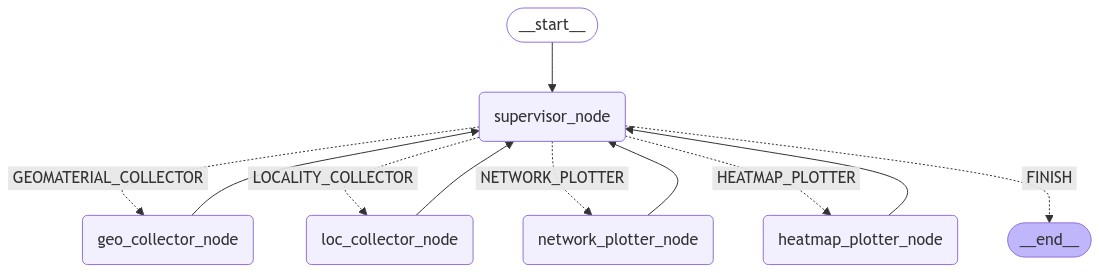

In [36]:
from IPython.display import Image, display

try:
    display(Image(compiled_graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

# Test

In [ ]:
from pprint import pprint

inputs = "i want you to plot network visualization for carbon and iron mineral but without Magnesium"
# inputs = "I want to know the spatial distribution of ophiolite."
# inputs = "i want you to plot histogram visualization for carbon and oxygen mineral but without Magnesium"
# inputs = "i want to order a burger"
# inputs = "trsghreiobje"
# run the agent
message_dict = {"messages": inputs}

# inputs = {"messages": "this is a testflight, please respond with Finish"}
for output in compiled_graph.stream(message_dict):
    for key, value in output.items():
        pprint(f"Finished running: {key}")

====in supervisor node====
User: i want you to plot network visualization for carbon and iron mineral but without Magnesium
supervisor result:  next='GEOMATERIAL_COLLECTOR' supervisor_reason='The user want to plot network visualization, need to collect mineral dataset first.'
====route to team members====
'Finished running: supervisor_node'
====in geo collector node====
====in geomaterial collecting function====
{'elements_exc': 'Mg', 'elements_inc': 'C,Fe', 'ima': True}


Fetching data:   0%|          | 0/28 [00:00<?, ?it/s]

Successfully saved 28 entries to /Users/blc/Documents/Manuscripts/2409_OpenLLMWorkflow/Code/jupyter/Evaluation/llama3.1/mindat_data/geomaterial_data.json
'Finished running: geo_collector_node'
====in supervisor node====
User: i want you to plot network visualization for carbon and iron mineral but without Magnesium
Step 0, Supervisor node: GEOMATERIAL_COLLECTOR
Step 1, Collector node: The Geomaterial Collector node has successfully saved the dataset to /Users/blc/Documents/Manuscripts/2409_OpenLLMWorkflow/Code/jupyter/Evaluation/llama3.1/mindat_data/geomaterial_data.json
supervisor result:  next='NETWORK_PLOTTER' supervisor_reason='The dataset is collected, and the user wants to see the network visualization'
====route to team members====
'Finished running: supervisor_node'
====in network plotter node====
'Finished running: network_plotter_node'
====in supervisor node====
User: i want you to plot network visualization for carbon and iron mineral but without Magnesium
Step 0, Supervisor

KeyboardInterrupt: 

In [45]:
from pprint import pprint

# inputs = "i want to plot the locality data for Norway in heatmap"
# inputs = 'can you plot the locality data for north Europe in heatmap.'
inputs = 'I want to plot the locality data for brazil and thailand in heatmap'
# inputs = "i want you to plot histogram visualization for carbon and oxygen mineral but without Magnesium"
# inputs = "i want to order a burger"
# inputs = "trsghreiobje"
# run the agent
message_dict = {"messages": inputs}

# inputs = {"messages": "this is a testflight, please respond with Finish"}
for output in compiled_graph.stream(message_dict):
    for key, value in output.items():
        pprint(f"Finished running: {key}")

====in supervisor node====
User: I want to plot the locality data for brazil and thailand in heatmap
supervisor result:  next='LOCALITY_COLLECTOR' supervisor_reason='I need to collect the locality dataset for plotting heatmap'
====route to team members====
'Finished running: supervisor_node'
====in loc collector node====
====in locality collecting function====
{'country': 'Brazil'}


Fetching data: 0it [00:00, ?it/s]

KeyboardInterrupt: 

# Evaluation

In [ ]:
%%script false --no-raise-error --no-raise-exception

messages = "i want you to plot network visualization for carbon and iron mineral but without Magnesium"
# inputs = "I want to know the spatial distribution of ophiolite."
# inputs = "i want you to plot histogram visualization for carbon and oxygen mineral but without Magnesium"
# inputs = "i want to order a burger"
# inputs = "trsghreiobje"
# run the agent

result = supervisor_chain.invoke({
                "members": members, 
                "messages": str(messages), 
                "options":options, 
                "errors": errors,
                "supervisor_example1": supervisor_example1,
                "supervisor_example2": supervisor_example2,
                "supervisor_example3": supervisor_example3,
            })


print("Supervisor Chain Output:", result)

Supervisor Chain Output: next='GEOMATERIAL_COLLECTOR' supervisor_reason='I need to collect the mineral dataset to execute the user request'


In [38]:
import json
from tqdm.notebook import tqdm

# Initialize statistics dictionary
statistics = {
    "FP": [],  # False Positive
    "FN": [],  # False Negative  
    "TP": [],  # True Positive
    "TN": []   # True Negative
}

# Read JSON file
with open('test_union_1104.json', 'r') as f:
    tasks = json.load(f)

# Iterate through each task and call LLM Chain
for task in tqdm(tasks, desc="Processing Tasks", total=len(tasks)):
    # Prepare input data

    messages = task["input"]
    input_data = {
                "members": members, 
                "messages": str(messages), 
                "options":options, 
                "errors": errors,
                "supervisor_example1": supervisor_example1,
                "supervisor_example2": supervisor_example2,
                "supervisor_example3": supervisor_example3,
            }

   # Call chain and capture output
    try:
        result = supervisor_chain.invoke(input_data)
        evaluation_output = result  # Assume result is in dictionary format

        # Add evaluation_output to task dictionary
        task["evaluation_output"] = str(evaluation_output)

        # Get next values for comparison
        output_next = task["output"].get("next")
        eval_next = next_parser(evaluation_output)

       # Classification statistics and add evaluation tag
        if eval_next == output_next:  # Predicted value matches actual value
            if eval_next == "FINISH":  # Matched finish state
                statistics["TN"].append(task["id"]) 
                task["evaluation_tag"] = "TN"  # True Negative - Correctly predicted finish
            else:  # Matched other states (continue to next step)
                statistics["TP"].append(task["id"])
                task["evaluation_tag"] = "TP"  # True Positive - Correctly predicted next step
        else:  # Predicted value does not match actual value
            if eval_next == "FINISH":  # Model predicted finish but should continue
                statistics["FN"].append(task["id"])
                task["evaluation_tag"] = "FN"  # False Negative - Incorrectly predicted finish
            else:  # Model predicted wrong next step
                statistics["FP"].append(task["id"])
                task["evaluation_tag"] = "FP"  # False Positive - Predicted wrong continue state

        # Optional: Add detailed evaluation information
        task["evaluation_details"] = {
            "expected_next": output_next,
            "predicted_next": eval_next,
            "is_match": eval_next == output_next,
            "tag": task["evaluation_tag"]
        }

    except Exception as e:
        print(f"Error processing task {task['id']}: {str(e)}")
        task["evaluation_tag"] = "ERROR"
        task["evaluation_details"] = {"error": str(e)}


def next_parser(JARGON: str):
    jargon_str = str(JARGON).upper()

    found_positions = {}
    # options = ['FINISH', 'GEOMATERIAL_COLLECTOR', 'LOCALITY_COLLECTOR', 'NETWORK_PLOTTER', 'HEATMAP_PLOTTER']

    for option in options:
        if option in jargon_str:
            found_positions[option] = jargon_str.index(option)
    
    # Return with the first value in the output
    if found_positions:
        return min(found_positions.items(), key=lambda x: x[1])[0]
    
    return None

# Save processed tasks and statistics to new JSON files  
with open('evaluated_tasks.json', 'w') as f:
    json.dump(tasks, f, indent=2)

# Save statistics to separate statistics file
with open('statistics.json', 'w') as f:
    json.dump(statistics, f, indent=2)

print("Task processing completed and saved to evaluated_tasks.json and statistics.json")

Processing Tasks:   0%|          | 0/152 [00:00<?, ?it/s]

Task processing completed and saved to evaluated_tasks.json and statistics.json


In [40]:
import json

with open('statistics.json', 'r') as f:
    statistics = json.load(f)

FP = len(statistics.get("FP", []))
FN = len(statistics.get("FN", []))
TP = len(statistics.get("TP", []))
TN = len(statistics.get("TN", []))

print(f"FP (False Positive): {FP}")
print(f"FN (False Negative): {FN}")
print(f"TP (True Positive): {TP}")
print(f"TN (True Negative): {TN}")

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

total_tasks = FP + FN + TP + TN
accuracy = (TP + TN) / total_tasks if total_tasks > 0 else 0

FP_ratio = FP / total_tasks if total_tasks > 0 else 0
FN_ratio = FN / total_tasks if total_tasks > 0 else 0
TP_ratio = TP / total_tasks if total_tasks > 0 else 0
TN_ratio = TN / total_tasks if total_tasks > 0 else 0

print(f"\nRate:")

print(f"FP Ratio: {FP_ratio:.2%}")
print(f"FN Ratio: {FN_ratio:.2%}")
print(f"TP Ratio: {TP_ratio:.2%}")
print(f"TN Ratio: {TN_ratio:.2%}")

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")

FP (False Positive): 63
FN (False Negative): 1
TP (True Positive): 73
TN (True Negative): 15

Rate:
FP Ratio: 41.45%
FN Ratio: 0.66%
TP Ratio: 48.03%
TN Ratio: 9.87%

Precision: 0.5368
Recall: 0.9865
F1 Score: 0.6952
Accuracy: 0.5789


# 4. Case-wise Evaluation

In [1]:
import json
from collections import defaultdict

def get_next_values(record):
    """
    Extract predicted and expected next values from evaluation_details
    
    Args:
        record: Dictionary containing evaluation details
        
    Returns:
        tuple: (predicted_next, expected_next) or (None, None) if not found
    """
    try:
        if 'evaluation_details' in record:
            details = record['evaluation_details']
            predicted_next = details['predicted_next']
            expected_next = details['expected_next']
            return predicted_next, expected_next
        return None, None
        
    except (KeyError, AttributeError, TypeError):
        return None, None

def calculate_accuracy_by_next(json_file):
    """
    Calculate accuracy for each unique expected next value
    
    Args:
        json_file (str): Path to the JSON file
        
    Returns:
        tuple: (results for each next, results for ongoing vs finish, overall stats)
    """
    try:
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        if not isinstance(data, list):
            raise ValueError("JSON data should be a list of records")
        
        # Initialize counters
        stats = defaultdict(lambda: {"total": 0, "matches": 0})
        status_stats = {
            "ongoing": {"total": 0, "matches": 0},
            "finish": {"total": 0, "matches": 0}
        }
        overall_stats = {"total": 0, "matches": 0}
        
        # Count matches
        for record in data:
            predicted_next, expected_next = get_next_values(record)
            
            if expected_next is not None:
                # Update overall statistics
                overall_stats["total"] += 1
                if predicted_next is not None and predicted_next == expected_next:
                    overall_stats["matches"] += 1
                
                # Count for individual next values based on expected_next
                stats[expected_next]["total"] += 1
                if predicted_next is not None and predicted_next == expected_next:
                    stats[expected_next]["matches"] += 1
                
                # Count for ongoing vs finish based on expected_next
                status = "finish" if expected_next.lower() == "finish" else "ongoing"
                status_stats[status]["total"] += 1
                if predicted_next is not None and predicted_next == expected_next:
                    status_stats[status]["matches"] += 1
        
        # Calculate accuracy for each next value
        results = {}
        for next_value, counts in stats.items():
            accuracy = counts["matches"] / counts["total"] if counts["total"] > 0 else 0
            results[next_value] = {
                "total": counts["total"],
                "matches": counts["matches"],
                "accuracy": accuracy
            }
        
        # Calculate accuracy for ongoing vs finish
        status_results = {}
        for status, counts in status_stats.items():
            accuracy = counts["matches"] / counts["total"] if counts["total"] > 0 else 0
            status_results[status] = {
                "total": counts["total"],
                "matches": counts["matches"],
                "accuracy": accuracy
            }
        
        # Calculate overall accuracy
        overall_accuracy = overall_stats["matches"] / overall_stats["total"] if overall_stats["total"] > 0 else 0
        overall_results = {
            "total": overall_stats["total"],
            "matches": overall_stats["matches"],
            "accuracy": overall_accuracy
        }
        
        return results, status_results, overall_results
        
    except FileNotFoundError:
        print(f"Error: File {json_file} not found")
        return {}, {}, {}
    except json.JSONDecodeError:
        print("Error: Invalid JSON format")
        return {}, {}, {}
    except Exception as e:
        print(f"Error: {str(e)}")
        return {}, {}, {}

def main():
    json_file = "evaluated_tasks.json"
    results, status_results, overall_results = calculate_accuracy_by_next(json_file)

    # Print overall accuracy first
    print("\nOverall Accuracy:")
    print("-" * 60)
    print(f"{'Total Cases':<30} {'Matches':<10} {'Accuracy':<10}")
    print("-" * 60)
    print(f"{overall_results['total']:<30} {overall_results['matches']:<10} {overall_results['accuracy']:.2%}")

    # Print detailed results for each next value
    print("\nAccuracy statistics by next value:")
    print("-" * 60)
    print(f"{'Next Value':<30} {'Total':<10} {'Matches':<10} {'Accuracy':<10}")
    print("-" * 60)
    for next_value, stats in sorted(results.items()):
        print(f"{next_value:<30} {stats['total']:<10} {stats['matches']:<10} {stats['accuracy']:.2%}")

    # Print summary for ongoing vs finish
    print("\nSummary - Ongoing vs Finish:")
    print("-" * 60)
    print(f"{'Status':<30} {'Total':<10} {'Matches':<10} {'Accuracy':<10}")
    print("-" * 60)
    for status, stats in status_results.items():
        print(f"{status:<30} {stats['total']:<10} {stats['matches']:<10} {stats['accuracy']:.2%}")

if __name__ == "__main__":
    main()


Overall Accuracy:
------------------------------------------------------------
Total Cases                    Matches    Accuracy  
------------------------------------------------------------
152                            88         57.89%

Accuracy statistics by next value:
------------------------------------------------------------
Next Value                     Total      Matches    Accuracy  
------------------------------------------------------------
FINISH                         68         15         22.06%
GEOMATERIAL_COLLECTOR          15         15         100.00%
HEATMAP_PLOTTER                28         25         89.29%
LOCALITY_COLLECTOR             10         8          80.00%
NETWORK_PLOTTER                31         25         80.65%

Summary - Ongoing vs Finish:
------------------------------------------------------------
Status                         Total      Matches    Accuracy  
------------------------------------------------------------
ongoing           